<a href="https://colab.research.google.com/github/ikinikar/reddit-cc-analysis-nlp/blob/main/CC_Reddit_Exploration_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview


**Backstory**

In this notebook, I will be analyzing a Reddit Climate Change Posts Dataset ( [Public Opinion on Climate Change](https://www.kaggle.com/datasets/asaniczka/public-opinion-on-climate-change-updated-daily)).

Climate change is an issue that I deeply care about and I often find discourse around the subject to be fascinating and under-investigated. Online discourse tends to provide a unique lens, as many will say things online that they would never say in-person. Consequently, there tends to be a larger degree of polarization in some areas online than in others. Upon finding this dataset, I asked myself five questions that I wanted to answer:

1.   Is climate change generally a polarizing topic on Reddit?
2.   Are people generally optimistic about our chances at fighting or adjusting to climate change?
3. What types of topics do people commonly connect to climate change on Reddit?
4. Are the post scores (upvotes - downvotes) strongly dependent on the topic and the sentiment expressed by the post?
5. How much variation exists within Reddit discourse around climate change?

**Plan**

To find out the answers to my questions, I decided to analyze the dataset in four specific ways.

1. Look at overall sentiment in posts and find out whether people on Reddit associated positive, negative, or neutral sentiments with climate change broadly.
2. Find out the main topics that are commonly discussed in the posts of the dataset and find out how much of the overall discourse each constitutes.
3. Conduct statistical analysis to find out whether the post scores are correlated with the topic and sentiment of a post.
4. Conduct clustering analysis to understand how cleanly the dataset falls into clusters based on topics, sentiments, and post scores.

# Setting Up and Pre-processing the Posts

Before I could dive into executing my plan and finding the answers to my questions, I had to first set up the project. This involved making imports, downloading NLTK-based resources, and pulling in the dataset.

I then had to clean the dataset, selecting the initial features I wanted to work with, removing duplicate posts, and taking a peek at what the dataset looked like.

Finally, I went about conducting pre-processing steps for NLP on the dataset. I used regular expressions to remove all punctuation. I used NLTK resources to remove stop words and conduct lemmatization (reducing words to their root form for consistency in analysis).

In [1]:
#General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt

#PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim

#Train-Test-Split
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#For scaling features
from sklearn.preprocessing import StandardScaler

#Regular Expressions
import re

#For Topic Finding
import gensim
from gensim import corpora

#For building a bar graph
import seaborn as sns
import matplotlib.patches as patches

#For building a dendogram
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#For correlation testing
from scipy.stats import kruskal

#For post-hoc testing
!pip install scikit_posthocs
import scikit_posthocs as sp

#NLTK imports + downloads
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

used_stopwords= set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
#Pulling in the dataset
from google.colab import drive
drive.mount('/content/gdrive')
df_initial = pd.read_csv("/content/gdrive/MyDrive/reddit_opinion_climate_change.csv")

Mounted at /content/gdrive


In [3]:
#Cleaning the dataset
#Isolating Non-null Posts
df_posts = df_initial[["post_id", "post_title", "post_self_text", "post_score"]]

#Removing duplicate posts
df_posts = df_posts.drop_duplicates()

#Removing null posts
df_posts = df_posts.dropna()

#Removing post id's
df_posts = df_posts.drop(columns=["post_id"])

df_posts.head()

,post_title,post_self_text,post_score
0,"Supercomputers don't lie, no more clouds from co2",https://www.intellinews.com/rising-carbon-emis...,45
1,"After Thirty Years Of Research, I Believe This...","First of all, if you look at all UFO footage e...",0
3,Earth will survive. We won’t.,It’s time to replace “we’re killing the planet...,12
9,"The Impact of Climate and CO2 on Flora, Fauna,...",Vegetation does not grow in the extreme colds ...,0
17,Where can I get the weather without climate hy...,Looking online at the temps which are cool in ...,41


In [4]:
#Using RegExes to remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

#Pre-processing steps for the posts
def post_preprocessing(post):

  #Removing punctuation
  post = remove_punctuation(post)


  #Tokenizing
  tokens = word_tokenize(post)

  #Removing stop words
  filtered_post = [word for word in tokens if word.lower() not in used_stopwords]

  #Lemmatization
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_post]

  return ' '.join(lemmatized_tokens)

In [5]:
#Applying pre-processing steps
df_posts["post_self_text"] = df_posts["post_self_text"].apply(post_preprocessing)
df_posts.head()

,post_title,post_self_text,post_score
0,"Supercomputers don't lie, no more clouds from co2",httpswwwintellinewscomrisingcarbonemissionswil...,45
1,"After Thirty Years Of Research, I Believe This...",First look UFO footage ever captured misidenti...,0
3,Earth will survive. We won’t.,time replace killing planet killing earth beco...,12
9,"The Impact of Climate and CO2 on Flora, Fauna,...",Vegetation grow extreme cold found North South...,0
17,Where can I get the weather without climate hy...,Looking online temp cool NYC date rest page sc...,41


# Applying Sentiment Analysis to the Dataset (Answering Q2)



I used [NLTK's](https://www.nltk.org/howto/sentiment.html) Sentiment Intensity Analyzer (SIA) & Valence Awareness Dictionary and sEntiment Reasoner (VADER) to categorize the posts into 0 (negative), 1 (positive), and 2 (neutral) sentiment categories.




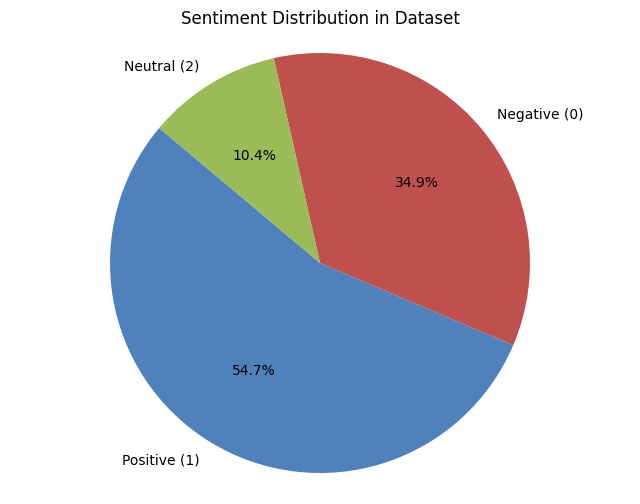

In [6]:
#Labeling sentiments across the dataset using SIA
sia = SentimentIntensityAnalyzer()

def predict_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    #Positive Case
    if sentiment_scores['compound'] >= 0.05:
        return 1
    #Negative Case
    elif sentiment_scores['compound'] <= -0.05:
        return 0
    #Neutral Case
    else:
        return 2

df_posts['post_sentiment'] = df_posts['post_self_text'].apply(predict_sentiment)

#Creating a pie chart of the sentiment composition of the dataset
sentiment_counts = df_posts['post_sentiment'].value_counts(normalize=True) * 100
sentiment_breakdown = sentiment_counts.rename(index={1: 'Positive (1)', 0: 'Negative (0)', 2: 'Neutral (2)'})


plt.figure(figsize=(8, 6))
plt.pie(
    sentiment_breakdown,
    labels=sentiment_breakdown.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#4F81BD', '#C0504D', '#9BBB59']
)
plt.title('Sentiment Distribution in Dataset')
plt.axis('equal')
plt.show()


**Question 2: Are people generally optimistic about our chances at fighting or adjusting to climate change? (Based on Sentiment Analysis Results)**

A large majority (54.7%) of posts in the dataset are positive, indicating that people are optimistic about our chances at fighting, mitigating, or adjusting to climate change. Having read quite a few posts in the dataset, I believe this is in part because of commentary on new possibilities for climate solutions, as reflected by renewable energy and legislation-based topics found later on. Some of the positive sentiment might actually be positive sentiment on a sub-topic as opposed to combatting climate change. The same could likely be said regarding negative sentiment, so it is likely that the percentages would look similar if I had a method to account for what people are positive about. I did consider that some of these positive sentiments were coming from climate denialism/conspiracy theories, but as you will read later on, this is not a large enough number of posts to make a difference in the sentiment breakdown.

I also wanted to point out that the neutral sentiment category (10.4%) is far below both the positive and negative sentiment categiories (89.6% combined). While the sentiment composition of the dataset could be directly symptomatic of polarization, I think that the sentiment alone does not answer the question of polarization.

Reddit is a platform where people generally tend to trade opinions and from what I have seen, the Climate Change subsection of Reddit is no different. Having a neutral opinion might be nuanced or it could be a sign of indifference on a subject. Similarly, positive or negative opinions could be nuanced and back up by facts. Therefore, the sentiment alone does not give a great window into the actual viewpoints people take, how based in data each of those viewpoints are, and whether the discourse is significantly polarized.


# Finding The Main Topics Touched on in the Dataset (Answering Q3)




I used a Latent Dirichlet Allocation (LDA) model (an unsupervised learning technique that determines main topics based on word distributions in a dataset) to find the main topics that the Climate Change Reddit touched on.

Additional Reading: [LDA Explained - IBM](https://www.ibm.com/topics/latent-dirichlet-allocation)

In [7]:
#Finding post topics using a LDA model
classes = 20

def tokenize(text):
    return nltk.word_tokenize(text.lower())

df_posts['tokens'] = df_posts['post_self_text'].apply(tokenize)

df_posts = df_posts[df_posts['tokens'].str.len() > 0]

#Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(df_posts['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_posts['tokens']]

#Train the LDA model on the entire corpus
lda_model = gensim.models.LdaModel(
    corpus,
    num_topics=classes,
    id2word=dictionary,
    passes=10,
    random_state=42 #Random seed for reproducibility
)

#Get global topics
topics = lda_model.print_topics(num_words=5)
print("Global Topics:")
for topic in topics:
    print(f"Topic {topic[0]}: {topic[1]}")
    print()

#Assign dominant topic to each post
def get_dominant_topic(tokens):
    bow = dictionary.doc2bow(tokens)
    topic_distribution = lda_model.get_document_topics(bow)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    return dominant_topic

#Apply function and split results into separate columns
df_posts['dominant_topic'], df_posts['topic_probability'] = zip(*df_posts['tokens'].apply(lambda x: get_dominant_topic(x)))

Global Topics:
Topic 0: 0.020*"city" + 0.017*"amp" + 0.011*"fire" + 0.009*"lake" + 0.007*"new"

Topic 1: 0.025*"rcp" + 0.025*"denver" + 0.012*"manmade" + 0.011*"critique" + 0.008*"disobedience"

Topic 2: 0.061*"climate" + 0.054*"action" + 0.042*"discussion" + 0.040*"please" + 0.040*"change"

Topic 3: 0.024*"climate" + 0.012*"change" + 0.010*"bill" + 0.006*"member" + 0.005*"public"

Topic 4: 0.024*"permafrost" + 0.005*"o2" + 0.005*"4c" + 0.005*"phaseout" + 0.004*"1kg"

Topic 5: 0.012*"war" + 0.010*"us" + 0.009*"country" + 0.008*"government" + 0.008*"world"

Topic 6: 0.035*"climate" + 0.021*"change" + 0.011*"global" + 0.011*"year" + 0.009*"would"

Topic 7: 0.007*"statewide" + 0.004*"hydroelectricity" + 0.004*"iaea" + 0.004*"meteorite" + 0.003*"wa"

Topic 8: 0.011*"alex" + 0.007*"medicine" + 0.006*"scientist" + 0.006*"field" + 0.006*"disease"

Topic 9: 0.015*"people" + 0.011*"like" + 0.009*"would" + 0.008*"dont" + 0.008*"think"

Topic 10: 0.027*"median" + 0.019*"und" + 0.009*"1900" + 0.00

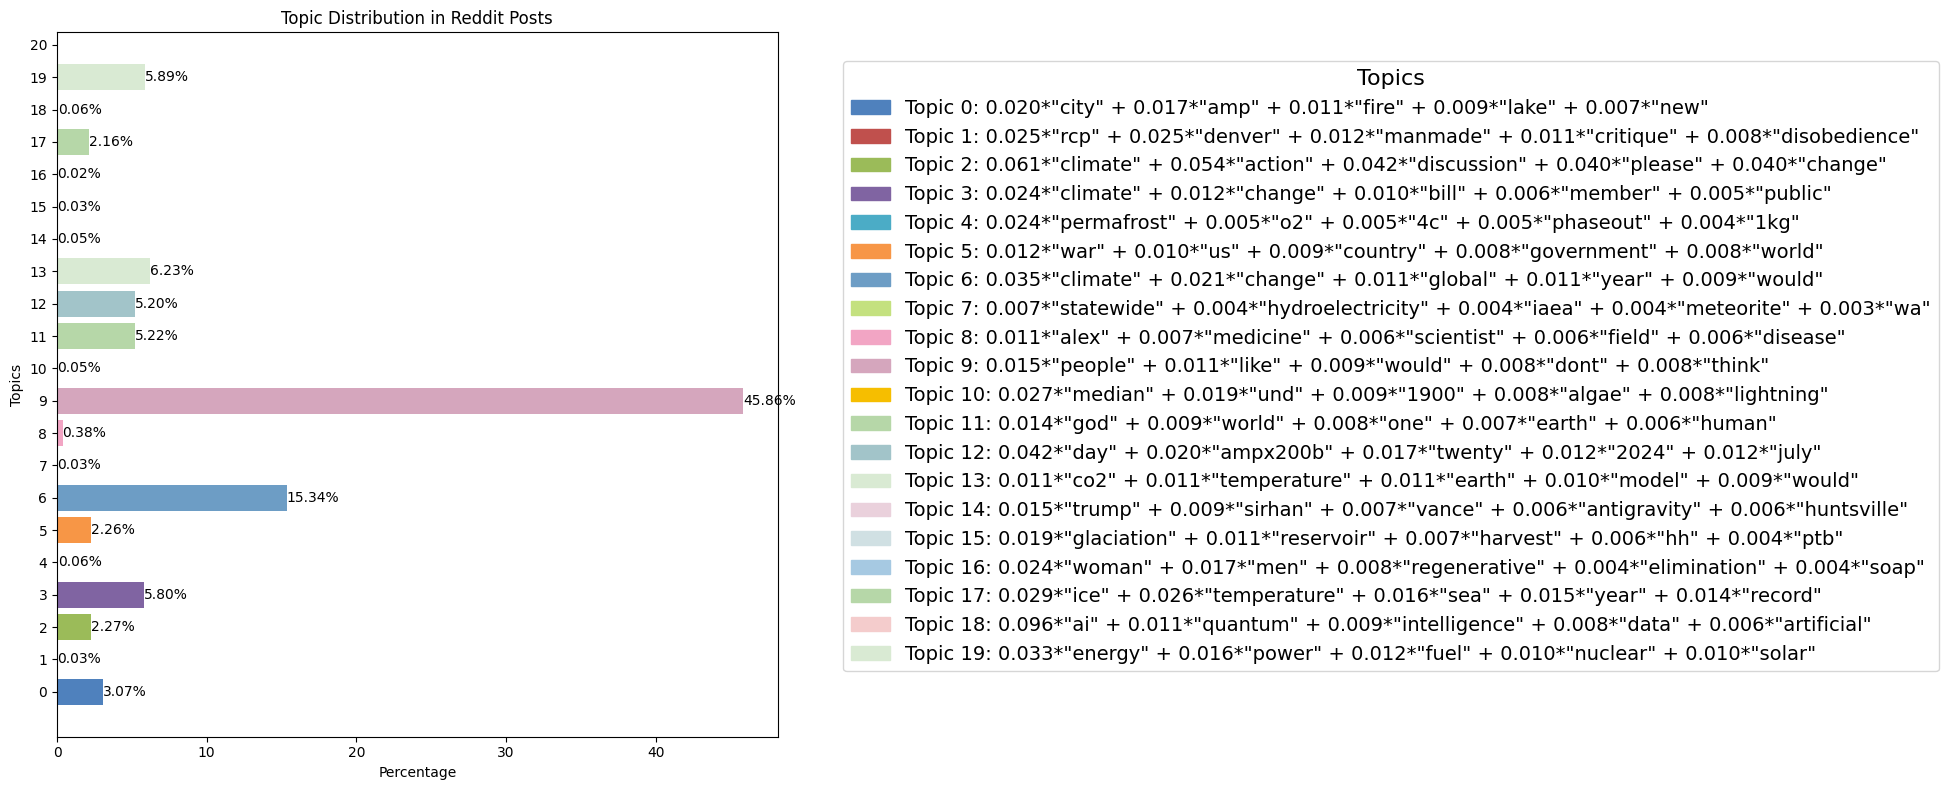

In [8]:
#Topic % breakdown
topic_counts = df_posts['dominant_topic'].value_counts(normalize=True) * 100

topic_counts_df = topic_counts.reset_index()
topic_counts_df.columns = ['Topic', 'Percentage']

topic_names = dict(topics)

topic_counts_df['Topic Name'] = topic_counts_df['Topic'].map(topic_names)

colors = {
    0: '#4F81BD',
    1: '#C0504D',
    2: '#9BBB59',
    3: '#8064A2',
    4: '#4BACC6',
    5: '#F79646',
    6: '#6D9DC5',
    7: '#C4E17F',
    8: '#F2A5C4',
    9: '#D5A6BD',
    10: '#F6BE00',
    11: '#B6D7A8',
    12: '#A2C4C9',
    13: '#D9EAD3',
    14: '#EAD1DC',
    15: '#D0E0E3',
    16: '#A6C9E2',
    17: '#B6D7A8',
    18: '#F4CCCC',
    19: '#D9EAD3'
}

#Map topics to colors
topic_counts_df['Color'] = topic_counts_df['Topic'].map(colors)

#Bar graph
plt.figure(figsize=(20, 8))
bars = plt.barh(
    topic_counts_df['Topic'],
    topic_counts_df['Percentage'],
    color=topic_counts_df['Color']
)

plt.title('Topic Distribution in Reddit Posts')
plt.xlabel('Percentage')
plt.ylabel('Topics')

#Formatting
for bar in bars:
    width = bar.get_width()
    plt.text(
        width - 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.2f}%',
        va='center',
        ha='left'
    )

#Setting y ticks
plt.yticks(ticks=range(0, 20 + 1))

#Adding a legend
patches_list = [
    patches.Patch(
        color=colors[topic],
        label=f"Topic {topic}: {name}"
    )
    for topic, name in topic_names.items()
]

plt.legend(handles=patches_list, title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16, borderaxespad=1.5)

#Display
plt.tight_layout()
plt.show()


**Question 3: What types of topics do people commonly connect to climate change on Reddit?**

Here are my interpretations of the types of posts that fall under each topic type found above. Please note that my interpretations are still speculative to an extent even if the topic words themselves are perhaps based on actual events/facts.

**Topic 0:** 0.020*"city" + 0.017*"amp" + 0.011*"fire" + 0.009*"lake" + 0.007*"new"

- Posts that discuss the effects of climate change in great detail. The terms city, fire, and lake suggests a discussion of recent increases in natural disasters.

**Topic 1:** 0.025*"rcp" + 0.025*"denver" + 0.012*"manmade" + 0.011*"critique" + 0.008*"disobedience"

- See [this report](https://https://www.coloradofiscal.org/wp-content/uploads/2021/08/CFI-Colorado2050-rev5-08022021r5-print.pdf) for why Denver/Colorado on a whole is greatly affected by climate change. The term manmade could be related to [the Biden administration setting funds for a project to remove artificial barriers between communities in Colorado](https://coloradobiz.com/biden-harris-administration-announces-37-47-million-for-locally-led-projects/).

**Topic 2:** 0.061*"climate" + 0.054*"action" + 0.042*"discussion" + 0.040*"please" + 0.040*"change"

- These posts might be urging for action and advocating for increased discussion on issues relating to climate change.

**Topic 3:** 0.024*"climate" + 0.012*"change" + 0.010*"bill" + 0.006*"member" + 0.005*"public"

- These posts might be related to legislation attempting to fight/mitigate climate change.

**Topic 4:** 0.024*"permafrost" + 0.005*"o2" + 0.005*"4c" + 0.005*"phaseout" + 0.004*"1kg"

- Could refer to global predictions/changes including permafrost thawing, changes in global temperatures, and the need to phaseout from greenhouse gasses.

**Topic 5:** 0.012*"war" + 0.010*"us" + 0.009*"country" + 0.008*"government" + 0.008*"world"

- Perhaps discussing geopolitical implications of climate change? Not very sure on this one.

**Topic 6:** 0.035*"climate" + 0.021*"change" + 0.011*"global" + 0.011*"year" + 0.009*"would"

- I think this is a very generic topic and probably does not actually point to anything in particular.

**Topic 7:** 0.007*"statewide" + 0.004*"hydroelectricity" + 0.004*"iaea" + 0.004*"meteorite" + 0.003*"wa"

- Refers to renewable energy sources including hydroelectricity and nuclear energy (IAEA is the International Atomic Energy Agency). Not too sure on what a Meteorite or Washington state might have to do with this.

**Topic 8:** 0.011*"alex" + 0.007*"medicine" + 0.006*"scientist" + 0.006*"field" + 0.006*"disease"

- Alex is a common enough name that it could refer to any prominent Alex who has spoken about climate change on the record. Medicine/scientist/disease suggests a discussion of epidemiology in some capacity.

**Topic 9:** 0.015*"people" + 0.011*"like" + 0.009*"would" + 0.008*"dont" + 0.008*"think"

- Another generic topic, probably does not mean much.

**Topic 10:** 0.027*"median" + 0.019*"und" + 0.009*"1900" + 0.008*"algae" + 0.008*"lightning"

- Might be discussing changes caused by climate change post-1900 but hard to be sure on this one.

**Topic 11:** 0.014*"god" + 0.009*"world" + 0.008*"one" + 0.007*"earth" + 0.006*"human"

- This could be the cliché of "one earth", "one world", etc - not sure how "god"/religion plays into this.

**Topic 12:** 0.042*"day" + 0.020*"ampx200b" + 0.017*"twenty" + 0.012*"2024" + 0.012*"july"

- Might refer to how hot July 2024 was - the 21st-23rd three day span set records for how hot it was.

**Topic 13:** 0.011*"co2" + 0.011*"temperature" + 0.011*"earth" + 0.010*"model" + 0.009*"would"

- Likely refers to climate science modeling of climate change.

**Topic 14:** 0.015*"trump" + 0.009*"sirhan" + 0.007*"vance" + 0.006*"antigravity" + 0.006*"huntsville"

- Antigravity and "Sirhan" (the man convicted for the assassination of Robert F.Kennedy Sr.) are both the topics of many conspiracy theories, something that Trump/Vance have been shown to peddle on many occasions.

**Topic 15:** 0.019*"glaciation" + 0.011*"reservoir" + 0.007*"harvest" + 0.006*"hh" + 0.004*"ptb"

- Could refer to how water sources/glaciers are effected by climate change.

**Topic 16:** 0.024*"woman" + 0.017*"men" + 0.008*"regenerative" + 0.004*"elimination" + 0.004*"soap"

- I honestly have no idea what this could be about beyond climate change as an existential threat to humanity.

**Topic 17:** 0.029*"ice" + 0.026*"temperature" + 0.016*"sea" + 0.015*"year" + 0.014*"record"

- This could be discussing the direct consequences of climate change.

**Topic 18:** 0.096*"ai" + 0.011*"quantum" + 0.009*"intelligence" + 0.008*"data" + 0.006*"artificial"

- Might be discussing how AI/quantum computing might affect climate change.

**Topic 19:** 0.033*"energy" + 0.016*"power" + 0.012*"fuel" + 0.010*"nuclear" + 0.010*"solar"

- Could be a discussion of alternative/green power sources.

# Statistical Analysis Section (Answering Q4 & Q1)

**Testing Whether There are Significant Differences Across Sentiment and Topic Groups with regards to Post Scores**

I used the [Kruskal-Wallis test](https://www.technologynetworks.com/informatics/articles/the-kruskal-wallis-test-370025) to check the difference in distribution between groups, as there is no guarantee that post scores follow anywhere near a regular distribution across different sentiment/topic categories.




In [9]:
#Testing correlation between sentiment and post_scores
groups_sentiments = [group["post_score"].values for name, group in df_posts.groupby("post_sentiment")]

h_statistic, p_value = kruskal(*groups_sentiments)
print("Testing between sentiment & post_scores:")
print(f"H-statistic: {h_statistic}, P-value: {p_value}")
print()


#Testing correlation between topics and post_scores
groups_topics = [group["post_score"].values for name, group in df_posts.groupby("dominant_topic")]

h_statistic_, p_value_ = kruskal(*groups_topics)
print("Testing between topics & post_scores:")
print(f"H-statistic: {h_statistic_}, P-value: {p_value_}")

Testing between sentiment & post_scores:
H-statistic: 59.62962597244107, P-value: 1.1261370346385239e-13

Testing between topics & post_scores:
H-statistic: 703.9571263862819, P-value: 5.212097703159862e-137


**Interpreting the results:**

1.   **Sentiment vs Post Scores:**  The low p-value of 1.126e-13 suggests that post-scores correlate significantly with sentiment categories. The H-value of 59.630 tells me that there is a notable difference in post scores across sentiment categories.

2.   **Topics vs Post Scores:** The extremely low p-value of 5.212e-137 tells me that the post-scores vary very strongly with the topic categories. The H-value of 703.957 tells me that there is a substantial difference in post scores across topic categories.


**Question 4: Are the post scores (upvotes - downvotes) strongly correlated with the topic and the sentiment expressed by the post?**

As the Kruskal-Wallis Test shows, the post scores are definitely correlated with the sentiment of a post but they are very strongly correlated with the main topic of a post. The high H-score for the topic categories suggests that the topic a post covers plays a major role in determining the amount of attention (and hence amount of upvotes) a post might recieve. To better understand which differences in post scores of topic categories most contribute to this high H-value, I had to conduct post-hoc testing.


**Post-Hoc Testing to Find Where Group Differences Are**

**The purpose of post-hoc testing:** Post-hoc testing is usually conducted after a correlation test across categories to determine which categories varied the most from one another while controlling for false positives. In this case I chose to conduct [Dunn](https://https://www.geeksforgeeks.org/how-to-perform-dunns-test-in-python/#) testing (usually intended for non-parametric data such as what I have here) with Bonferroni correction (to adjust for the fact I am making multiple comparisons).



In [10]:
#Post-hoc testing on sentiment categories
posthoc_sentiment = sp.posthoc_dunn(df_posts, val_col='post_score', group_col='post_sentiment', p_adjust='bonferroni')

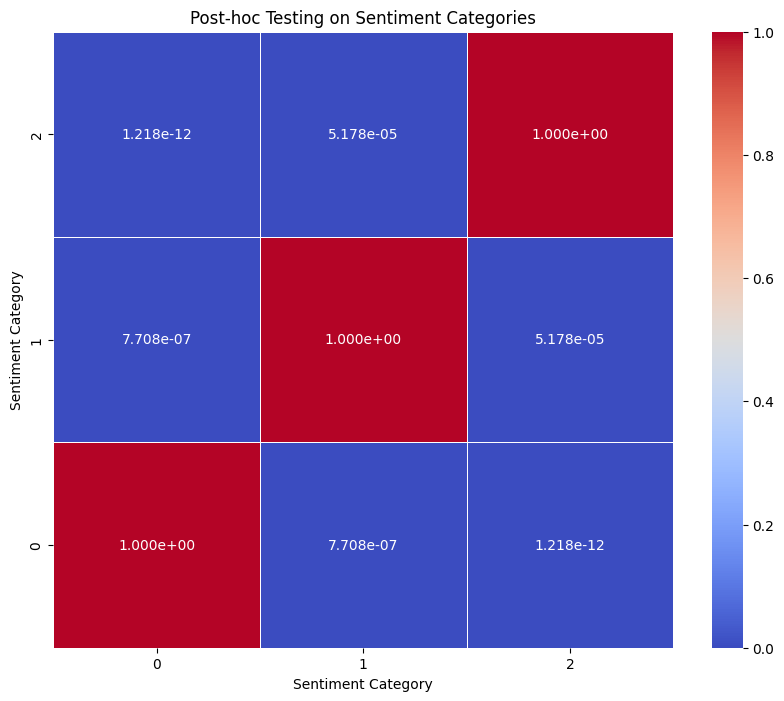

In [11]:
#Heatmap for sentiment categories
#Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(posthoc_sentiment, annot=True, cmap='coolwarm', fmt=".3e", linewidths=.5)

plt.gca().invert_yaxis()

#Add labels and title
plt.title('Post-hoc Testing on Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Sentiment Category')

#Show the plot
plt.show()

**Interpreting the Sentiment Post-hoc Heatmap**

Aside from comparing a category to itself which always will yield 1 (to represent the lack of difference), all other category comparisons show a small value representing the significant difference in post score distribution across all three sentiment categories.

In [12]:
#Post-hoc testing on different topics
posthoc_topics = sp.posthoc_dunn(df_posts, val_col='post_score', group_col='dominant_topic', p_adjust='bonferroni')

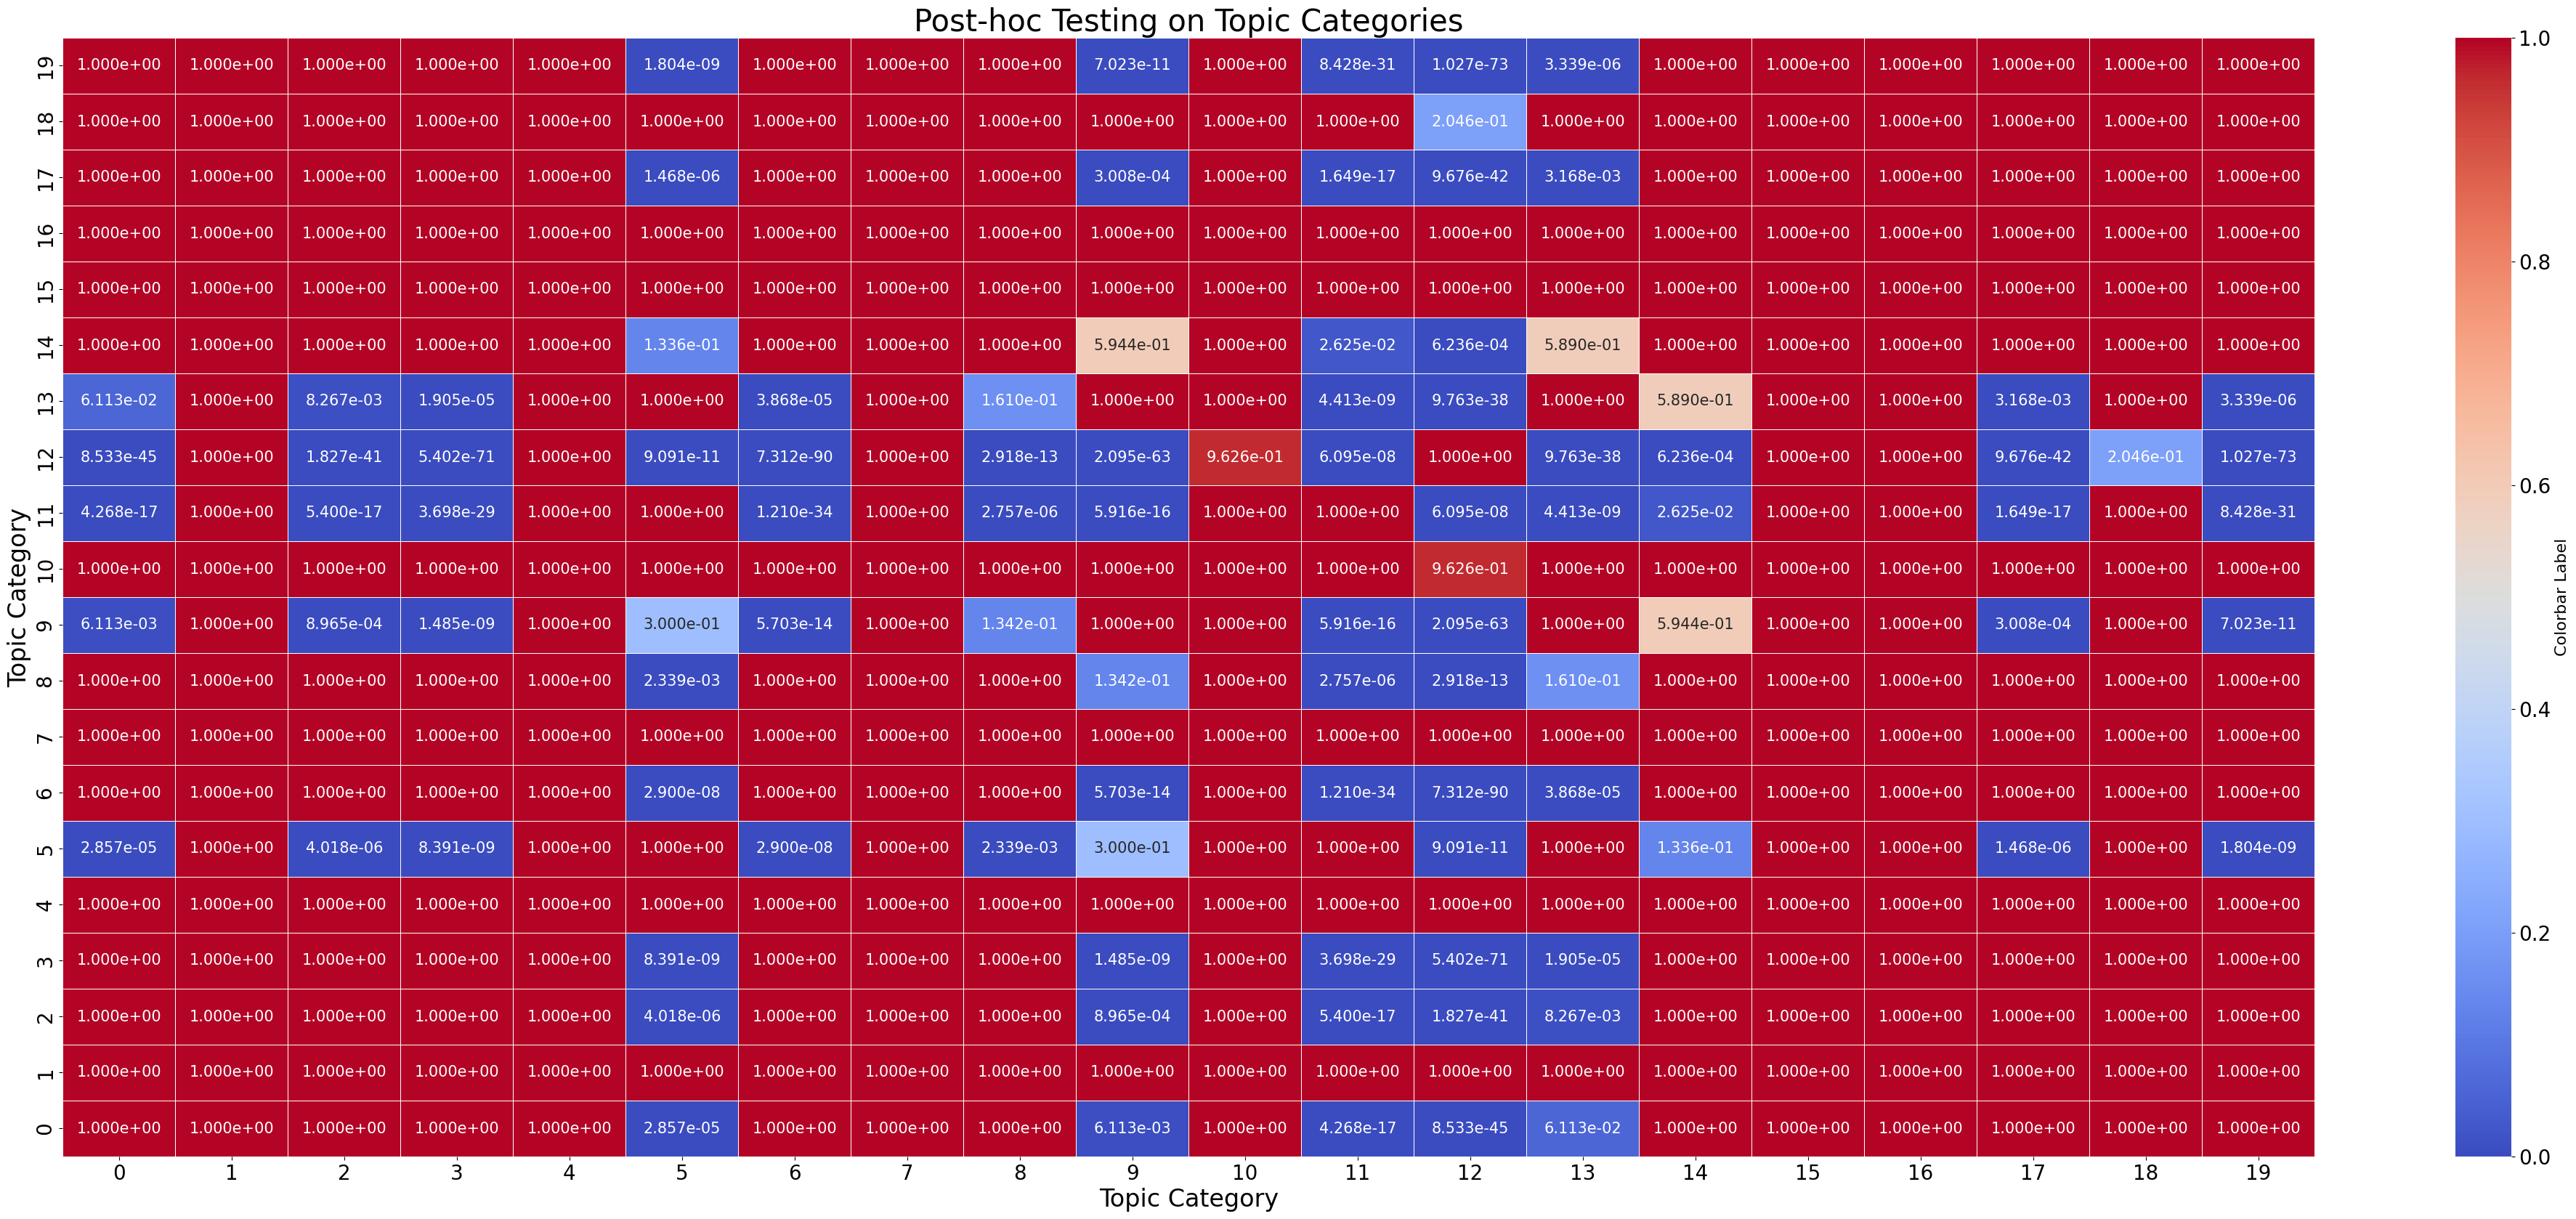

In [13]:
#Heatmap for topic categories
#Create the heatmap
plt.figure(figsize=(50, 20))
sns.heatmap(posthoc_topics, annot=True, cmap='coolwarm', fmt=".3e", linewidths=.5, annot_kws={"size": 15})

plt.gca().invert_yaxis()
plt.title('Post-hoc Testing on Topic Categories', fontsize=30)
plt.xlabel('Topic Category', fontsize=24)
plt.ylabel('Topic Category', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

colorbar = plt.gca().collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)
colorbar.set_label('Colorbar Label', fontsize=16)

plt.show()

**Interpreting the Topic Post-hoc Heatmap**

Unlike the sentiment categories heatmap, the topic categories heatmap shows that many categories actually have not much difference in post score distribution one another in terms of correlation with post scores. This makes sense intutively, as some of the topic categories ended up being fairly generic. However, the few categories that do differ from one another in post score distribution seem to differ by a lot as indicated by the spots of darker blue on the heatmap.



**Bar Graphs of Average Post Score By Categories**

To help better visualize which sentiment and topic categories recieve the most attention on average (by proxy of post score), I created bar graphs.

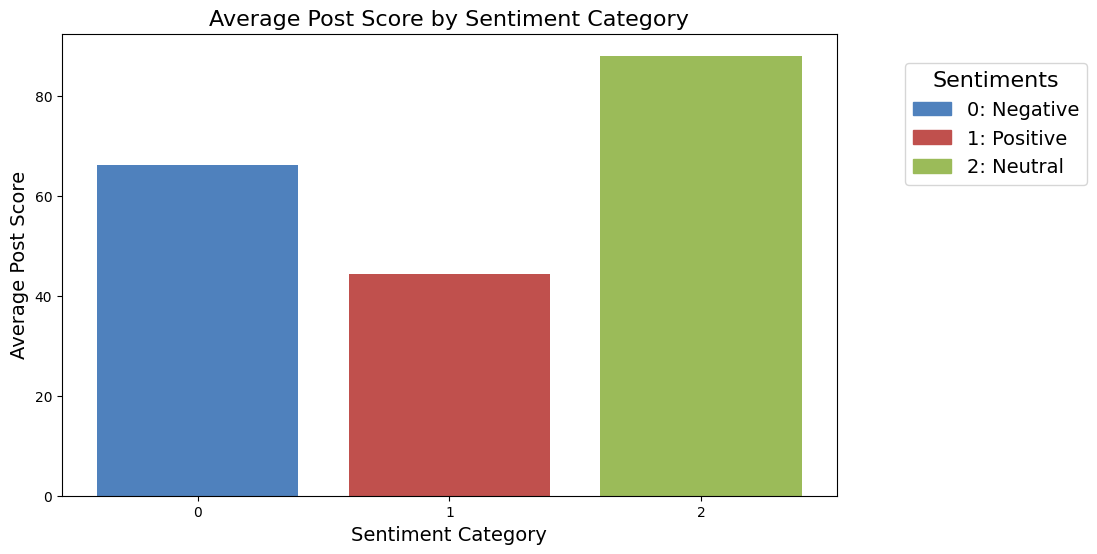

In [14]:
#Sentiments
average_scores_by_sentiment = df_posts.groupby('post_sentiment')['post_score'].mean().reset_index()
average_scores_by_sentiment.columns = ['Sentiment Category', 'Average Post Score']

sentiment_colors = {
    0: '#4F81BD',
    1: '#C0504D',
    2: '#9BBB59'
}

bar_colors = [sentiment_colors[sentiment] for sentiment in average_scores_by_sentiment['Sentiment Category']]

#Bar graph
plt.figure(figsize=(10, 6))
plt.bar(
    average_scores_by_sentiment['Sentiment Category'],
    average_scores_by_sentiment['Average Post Score'],
    color=bar_colors
)

plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Average Post Score', fontsize=14)
plt.title('Average Post Score by Sentiment Category', fontsize=16)

plt.xticks([0, 1, 2])
plt.legend(
    handles=[
        patches.Patch(color='#4F81BD', label='0: Negative'),
        patches.Patch(color='#C0504D', label='1: Positive'),
        patches.Patch(color='#9BBB59', label='2: Neutral')
    ],
    title="Sentiments",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16,
    borderaxespad=1.5
)

plt.show()


**Interpreting The Average Post Score by Sentiment Category Bar Graph**

I think neutral posts might be recieving the highest post scores on average because they are non-controversial most of the time. While positive/negative posts are more opinionated and more likely to recieve downvotes, neutral posts might be getting upvotes with very few downvotes, resulting in higher scores on average.

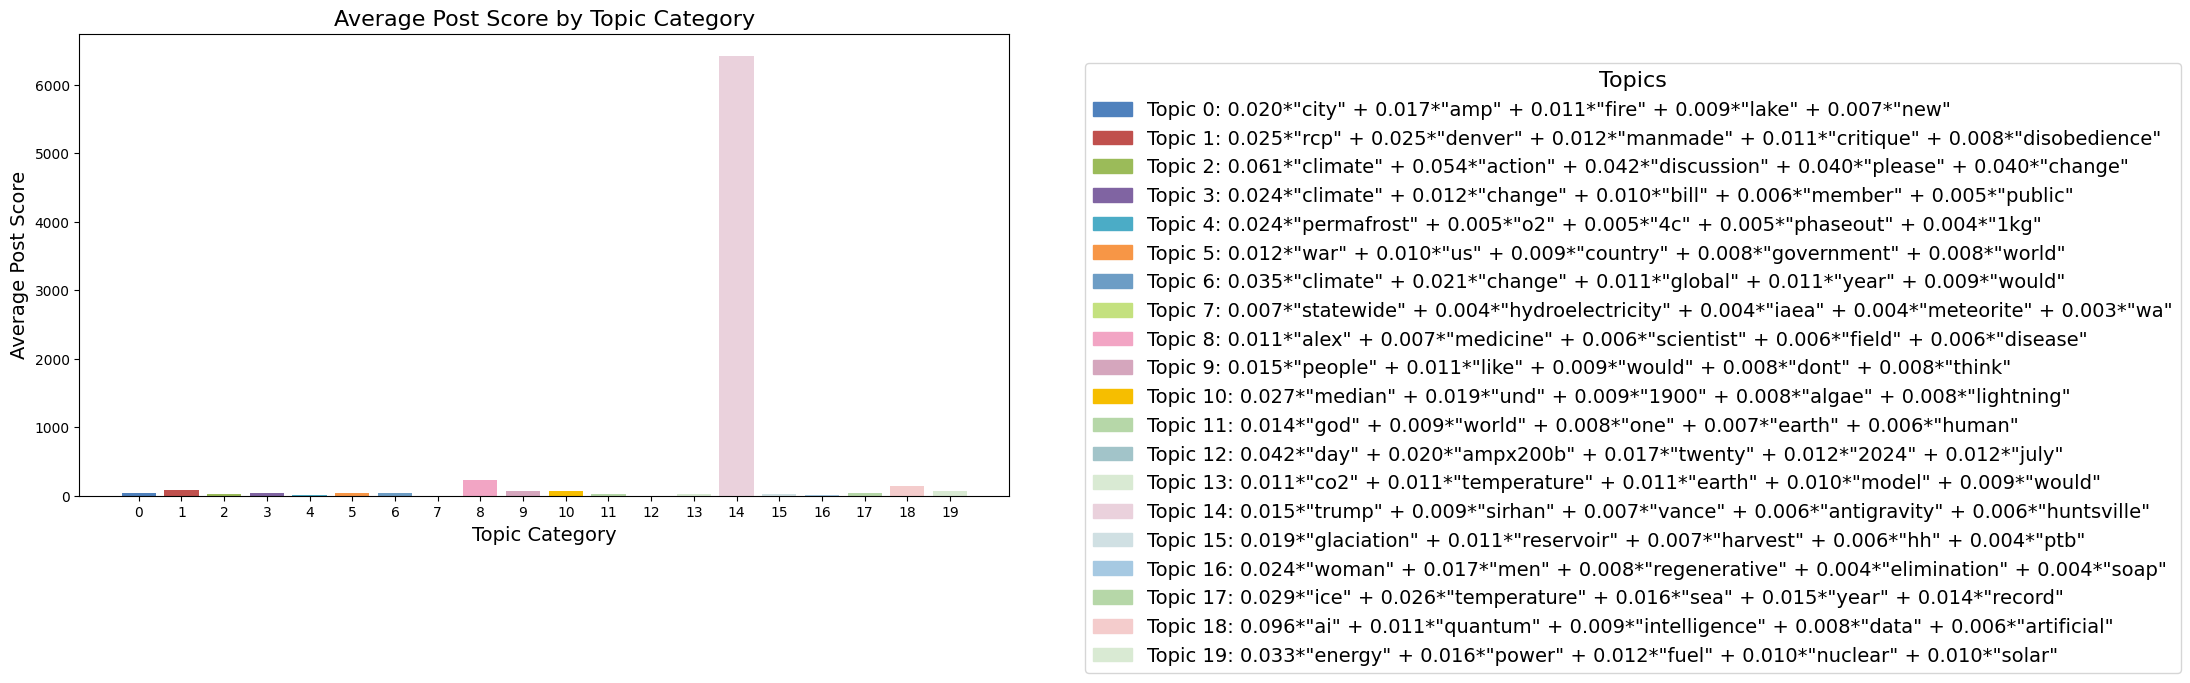

In [15]:
#Topics

#Grouping by topic and calculating the average post score
average_scores_by_topic = df_posts.groupby('dominant_topic')['post_score'].mean().reset_index()
average_scores_by_topic.columns = ['Topic Category', 'Average Post Score']

colors = {
    0: '#4F81BD',
    1: '#C0504D',
    2: '#9BBB59',
    3: '#8064A2',
    4: '#4BACC6',
    5: '#F79646',
    6: '#6D9DC5',
    7: '#C4E17F',
    8: '#F2A5C4',
    9: '#D5A6BD',
    10: '#F6BE00',
    11: '#B6D7A8',
    12: '#A2C4C9',
    13: '#D9EAD3',
    14: '#EAD1DC',
    15: '#D0E0E3',
    16: '#A6C9E2',
    17: '#B6D7A8',
    18: '#F4CCCC',
    19: '#D9EAD3'
}

bar_colors = [colors[topic] for topic in average_scores_by_topic['Topic Category']]

#Bar Graph
plt.figure(figsize=(12, 6))
plt.bar(
    average_scores_by_topic['Topic Category'],
    average_scores_by_topic['Average Post Score'],
    color=bar_colors
)

plt.xlabel('Topic Category', fontsize=14)
plt.ylabel('Average Post Score', fontsize=14)
plt.title('Average Post Score by Topic Category', fontsize=16)

plt.xticks([x for x in range(len(average_scores_by_topic))])


#Adding a legend
patches_list = [
    patches.Patch(
        color=colors[topic],
        label=f"Topic {topic}: {name}"
    )
    for topic, name in topic_names.items()
]

plt.legend(
    handles=patches_list,
    title="Topics",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16,
    borderaxespad=1.5
)

plt.show()


**Interpreting the Average Post Score by Category Bar Graph**

All of the topics average under 1000 in score except for the elephant in the room, topic 14. Topic 14 is the outlier, averaging a massive post score of 6000. And to be clear this isn't the result of a single post. While Topic 14 amounts to a mere 0.05% of the dataset's posts, that is still somewhere around 300-350 posts that are averaging such a high number. Even if some of these posts failed to garner that level of attention, it is clear that many of them did for the average to be so high. It makes sense considering that Topic 14's keywords point heavily in the direction of conspiracy theories. I think it is entirely plausible that these posts are echo chambers that are spreading misinformation. As shown in the next graph, the reactions to Topic 14 posts tend closer to positive suggesting that people creating these posts have positive perceptions of what are likely conspiracy theories.

**Analyzing Average Sentiment of a Topic**

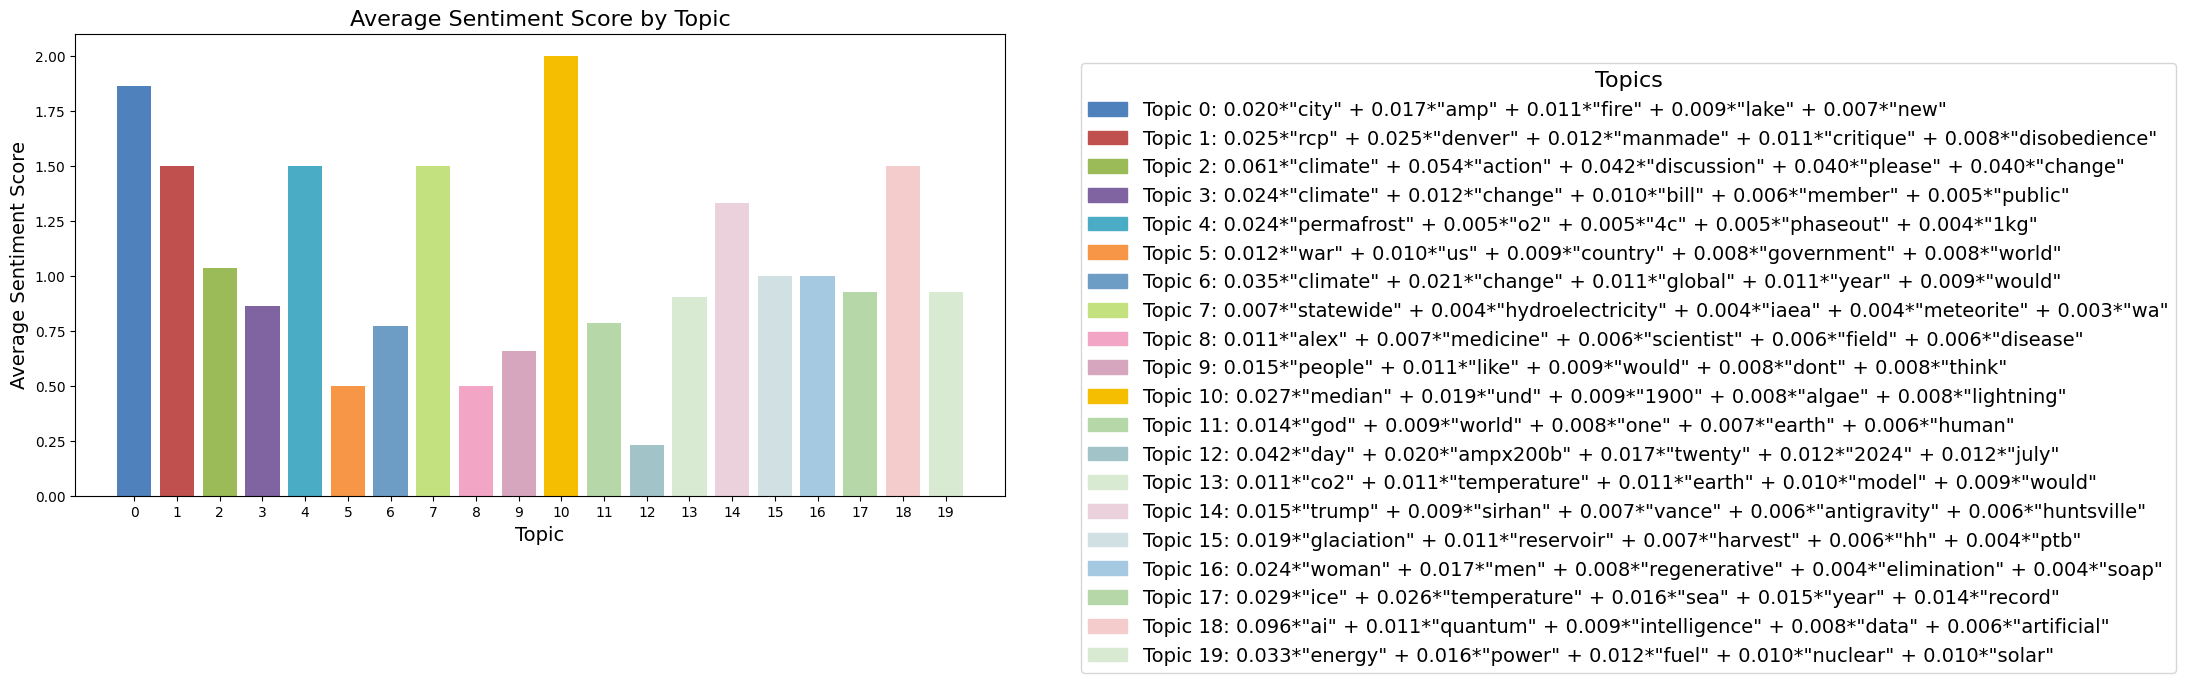

In [16]:
#Analyzing Average Sentiment by Topic
average_sentiment_by_topic = df_posts.groupby('dominant_topic')['post_sentiment'].mean().reset_index()

average_sentiment_by_topic.columns = ['Topic', 'Average Sentiment Score']

#Bar Graph
plt.figure(figsize=(12, 6))
plt.bar(average_sentiment_by_topic['Topic'], average_sentiment_by_topic['Average Sentiment Score'], color=bar_colors)

plt.xlabel('Topic', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.title('Average Sentiment Score by Topic', fontsize=16)

plt.xticks([x for x in range(20)])

#Adding a legend
patches_list = [
    patches.Patch(
        color=colors[topic],
        label=f"Topic {topic}: {name}"
    )
    for topic, name in topic_names.items()
]

plt.legend(
    handles=patches_list,
    title="Topics",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16,
    borderaxespad=1.5
)

plt.show()

**Interpreting the Average Sentiment Score by Topic Graph**

The vast majority of topics point show an average sentiment close to positive or neutral. The few topics that do display a closer to negative sentiment tend to be heavier topics that have deeply effected many in the status quo - these include world records for heat, disease/epidemics, and war.

**Question 1: Is climate change generally a polarizing topic on Reddit?**

I believe that the variety of topics and the nuance in terms of references for many of them suggests that a majority of discussion on Reddit about Climate Change is based in some sort of facts or data. That neutral-leaning posts recieve higher post scores on average is a good thing - it suggests that many are willing to hear out nuanced perspectives.

However, Topic 14 is a clear warning as to what can happen when an echo chamber is created. There are few checks and balances online to help introduce facts/data to a conversation when many in a space (sub-Reddits that spread conspiracy theories) buy into specific narratives that are designed for the profit/gain of a few. These spaces, no matter how small, always have real consequences and ought to be discussed seriously when considering the impact of social media on the public.

# Conducting Hierarchical Clustering and Creating a Dendogram (Answering Q5)



**Why Hierarchical Clustering?**

I chose to use hierarchical clustering for a few reasons
- I wanted to understand how far apart points were in terms of post scores, topics, and sentiments without specifying beforehand how many clusters would be necessary.
- I did not want to assume a cluster shape going into the clustering process.
- I have a mix of categorical (sentiment, topics) and continuous data (post scores)

Normally, Euclidean distance is not used for a mix of categorical and continuous data but due to the limits of computing resources on my computer, I had to settle for using that while scaling features to help the clustering process.

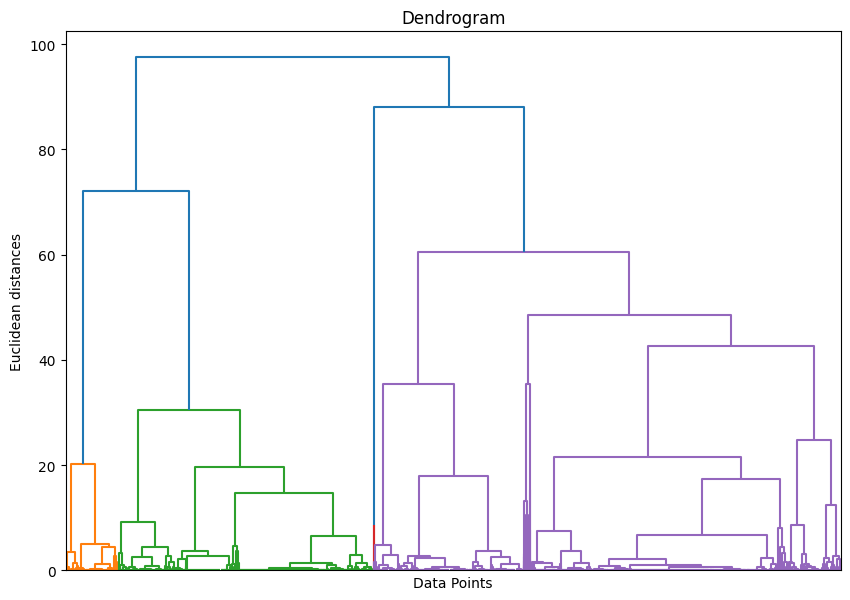

In [17]:
#Encode categorical features
df_posts['post_sentiment'] = df_posts['post_sentiment'].astype('category').cat.codes
df_posts['dominant_topic'] = df_posts['dominant_topic'].astype('category').cat.codes

X = df_posts[['post_sentiment', 'dominant_topic', 'post_score']].values

#Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Perform hierarchical clustering
Z = linkage(X_scaled, method='ward')

#Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, no_labels=True)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean distances')
plt.show()

max_d = 10
clusters = fcluster(Z, max_d, criterion='distance')

**Question 5: How much variation exists within Reddit discourse around climate change? (Based on Hierarchical Clustering Results)**

Based on the dendogram, it is evident that there are many outliers (the points that got grouped in towards the very end). The hierarchical groupings lump many points that are far apart together. This suggests that even within the clusters that the algorithm came up with, there are still large degrees of variation. The result is consistent with the high variety of topics and post scores found in the dataset.

For a quick primer on reading dendograms, check out this [document from Wheaton College](https://wheatoncollege.edu/wp-content/uploads/2012/08/How-to-Read-a-Dendrogram-Web-Ready.pdf).

# Conclusion (Notes for Future Iterations of This Project)



I want to conclude by pointing out directions I might take for future development of this project.

*   I am keen to use a transformer model instead of SIA/VADER, as it will prove to be a far more accurate indication of sentiment. I want to do so in a way that is ultimately in line with the ethos of the project, minimizing any carbon emissions from my usage of a transformer model.
*   Additionally, I want to find topics in a different way. While LDA is great at obtaining a general sense of common topics, there are other unsupervised learning techniques that do similar things and have their own advantages. I hope that in doing this, I can generate topic summaries that are more informative of their categories. It might also prove useful to have a topic breakdown for each post individually.
*   Using explainable AI frameworks might allow me to trace the analysis of sentiment, topics, and more that is occurring, helping me interpret results in far more detail.

I believe that pursuing these directions will prove to be fertile grounds for answering new questions and refining the answers I found this time around.

**Thank you for checking out my Colab notebook - I hope you enjoyed my analysis of this dataset!**